## Specific Test V: Exploring Transformers

`Task`: Use a vision transformer method of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.

`Dataset`: [lenses.tgz](https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharinghttps://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing) - Google Drive

`Dataset Description`: A set of simulated strong gravitational lensing images with and without substructure 

`Evaluation Metrics`: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

## Downloading and unzipping Data

Avoid this if you have downloaded data locally.

In [1]:
# Downloading Task 5 data
! gdown "16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"

Downloading...
From: https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A&confirm=t
To: /content/dataset.zip
100% 1.13G/1.13G [00:08<00:00, 129MB/s]


Here we are extracting the given data in a folder name `test_5`.

In [2]:
! mkdir test_5

! tar xvzf lens_finding.tgz -C test_5

Analysing the dataset, we will  need  to split dataset into train and validation sets. We have data of 2 classes,  `sub`and `no_sub` lenses.

## Installing and importing libraries

In [1]:
! pip install timm -q

In [3]:

import os
import cv2
import timm
import json
import random
import numpy as np
import pandas as pd
from glob import glob
from  pathlib import Path
from astropy.io import fits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Pytorch Related imports
import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


c:\Users\Sawradip\miniconda3\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for CumulativeSumOptions not exposed
  .format(class_name), RuntimeWarning)
c:\Users\Sawradip\miniconda3\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for ListSliceOptions not exposed
  .format(class_name), RuntimeWarning)
c:\Users\Sawradip\miniconda3\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for RankOptions not exposed
  .format(class_name), RuntimeWarning)


## Vizualizing Images

Here we define a function `show_imgs`, to display a grid  of image from a specific class.

In [4]:

def show_imgs(cls, rows= 3 , cols = 5):
    """
    Display Images of a specific class
    """
    n_imgs = cols * rows
    Path('assets').mkdir(exist_ok = True)
    paths = random.sample(glob(f"test_5/lenses/{cls}/*.jpg"), k = n_imgs)

    fig, axs = plt.subplots(rows, cols, figsize=(15, 9))
    axs = axs.flatten()
    for path, ax in zip(paths, axs):
        img = cv2.imread(path)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'Class - {cls}', fontsize=30)
    plt.tight_layout()

    plt.savefig(Path('assets')/f"Class - {cls}.png", dpi = 600)
    plt.show()



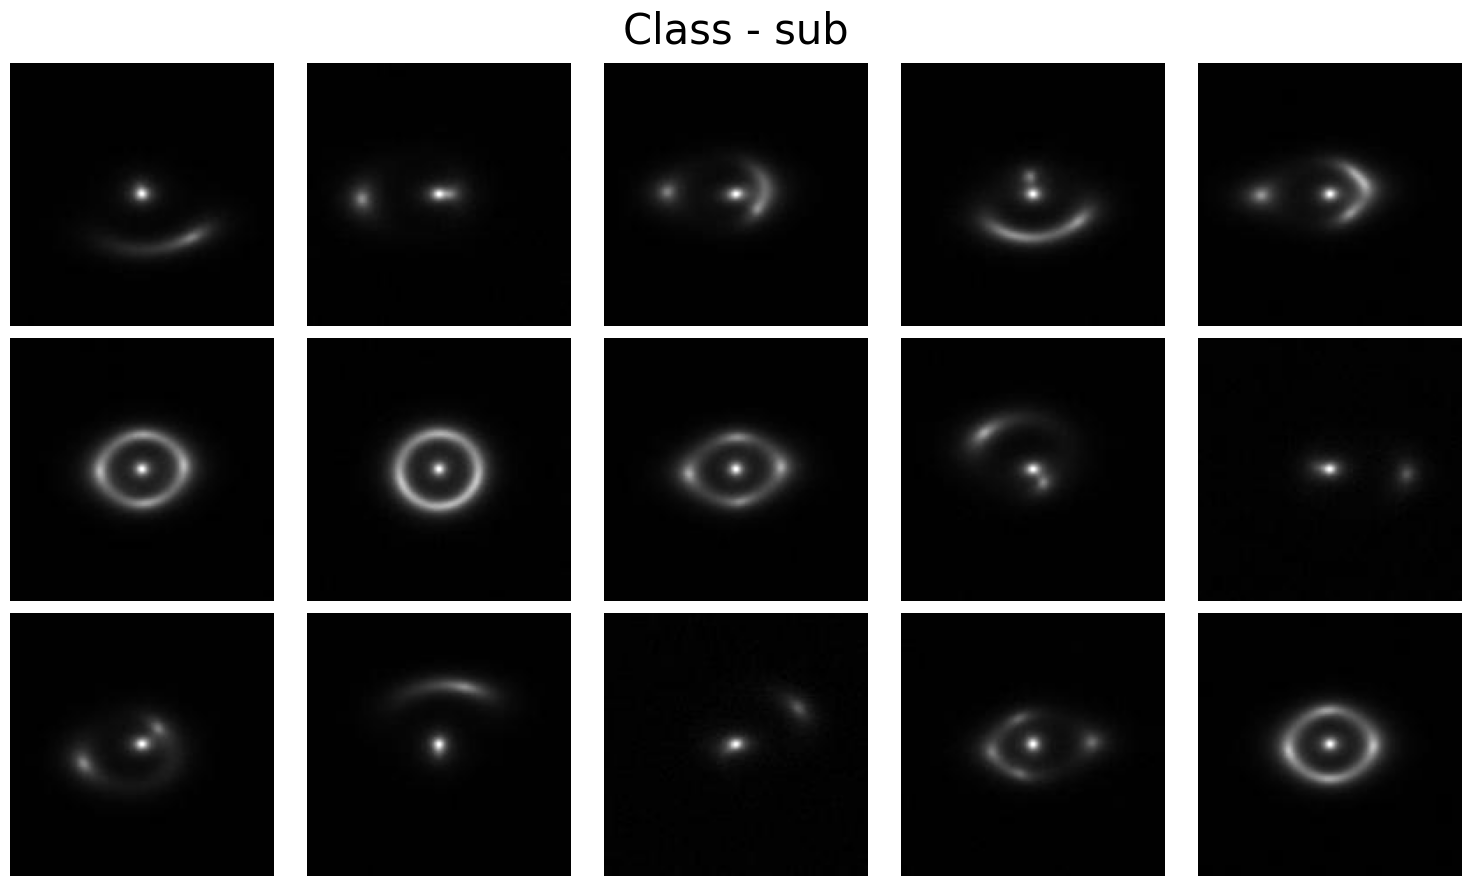

In [5]:
show_imgs('sub')

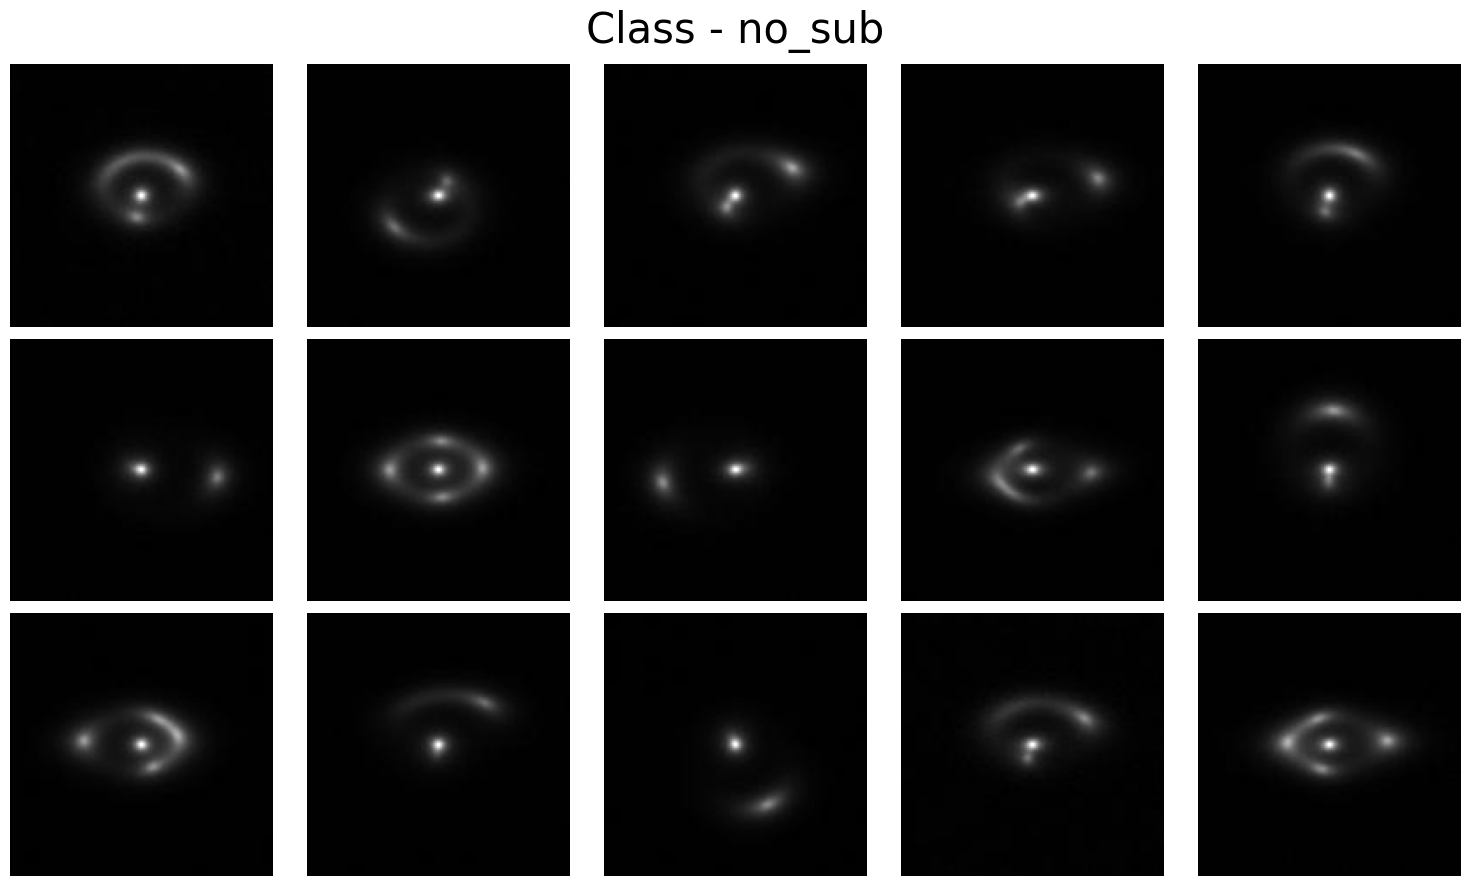

In [6]:
show_imgs('no_sub')

##  Preparing Dataset and Dataloader

In [7]:
# Define a dictionary of image transforms for training and validation datasets.
image_transforms = {
    # For the "train" dataset, apply the following transforms in sequence:
    "train": transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor.
        transforms.Resize(224),  # Resize the image to 224x224 pixels.
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically
        transforms.RandomRotation([-90, +90]),  # Randomly rotate the image
    ]),

    # For the "val" dataset, apply the following transforms in sequence:
    "val": transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor.
        transforms.Resize(224)  # Resize the image to 224x224 pixels.
    ])
}

In [8]:
from sklearn.model_selection import train_test_split

files = glob(f"test_5/lenses/*/*.jpg")
train_files, test_files = train_test_split(files, test_size = 0.1, random_state = 42)

len(test_files)

1000

In [9]:

import torch
from torch.utils.data import Dataset

class IsSubData(Dataset):
    def __init__(self, files, transform):
        self.files =  files
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        path = self.files[i]
        img = cv2.imread(path)
        label = 0 if 'no_sub' in path else 1
        arr = self.transform(img)[0]
        arr= torch.stack([arr,arr,arr])
        return arr.to(torch.float32), torch.tensor([label]).to(torch.float32)
    
train_dset = IsSubData(train_files, image_transforms["train"])
val_dset = IsSubData(test_files, image_transforms["val"])

In [10]:
# Testing the dataloader
train_dset.__getitem__(34)[0].shape, train_dset.__getitem__(34)[1]

(torch.Size([3, 224, 224]), tensor([1.]))

## Trainer class 

This `Trainer` class will manage the whole training and validation pipeline.

In [11]:


class Trainer:

    # Constructor function of the Trainer class
    def __init__(self, model_name, model, train_dset, val_dset, loss_type, optim_type, batch_size, load = False):
        
        # Sets the device to GPU if it is available, otherwise uses CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Stores the given model_name
        self.model_name = model_name

        # Creates a path object with the given model_name
        self.model_dir = Path(model_name)

        # Creates a directory with the given model_name if it does not exist
        if load:
            self.model_dir.mkdir(exist_ok=True)
        else:
            self.model_dir.mkdir()

        # Assigns the given model to the device
        self.model = model.to(self.device)

        # Stores the given training dataset
        self.train_dset = train_dset

        # Stores the given validation dataset
        self.val_dset = val_dset

        # Creates train and validation  dataloaders  from  provided  datasets.
        self.train_loader = self.get_dataloader(dl_type = "train" , batch_size = batch_size)
        self.val_loader = self.get_dataloader(dl_type = "val" , batch_size = batch_size)

        # Creates loss function and optimizer
        self.loss_fn = self.get_loss(loss_type)
        self.optimizer = self.get_optimizer(optim_type)

        # Creates dictionary to log all training informations
        self.info_dict = {}
        self.info_dict["last_epoch"] = -1
        self.info_dict["best_acc"] = 0


    def get_loss(self, loss_type):

        # If loss_type is Cross Entropy, return the CrossEntropyLoss function
        if loss_type == "ce":
            return nn.CrossEntropyLoss(reduction='mean')
        elif loss_type == "mse":
            return nn.MSELoss(reduction='mean')
        else:
            raise TypeError("This loss type is supported for now") 
    

    def get_optimizer(self, optim_type):

        # If optimizer type is Adam, return Adam optimizer
        if optim_type == "adam":
            return Adam(self.model.parameters(), lr=1e-6)
        
        # If optimizer type is SGD, return SGD optimizer
        elif optim_type == "sgd":
            return SGD(self.model.parameters(), lr=0.1, momentum=0.9)
        
        # Otherwise, raise a TypeError.
        else:
            raise TypeError("This optimizer type is not yet supported") 

    
    def get_dataloader(self, dl_type , batch_size):
        
        # If the data loader type is 'train', return a DataLoader with the training dataset
        if dl_type == "train":
            return DataLoader(self.train_dset, batch_size=batch_size, shuffle=True)
        
        # If the data loader type is 'val', return a DataLoader with the validation dataset
        elif dl_type == "val":
            return DataLoader(self.val_dset, batch_size=batch_size, shuffle=False)
        
        # Otherwise, raise a TypeError.
        else:
            raise TypeError("Only support train and validation dataloader currently.")


    # define a method for training one epoch
    def train_one_epoch(self):
        
        # set the model to train mode
        self.model.train()
        
        # initialize variables for tracking training loss and accuracy
        train_loss = 0.0
        correct = 0
        total = 0
        
        # iterate over the training loader
        for data, target in tqdm(self.train_loader):
            # move data and target to device
            data, target = data.to(self.device), target.to(self.device)
            
            # zero the optimizer gradients
            self.optimizer.zero_grad()
            
            # get the model output and update weights
            output = self.model(data)
            loss = self.loss_fn(output, target)
            loss.backward()
            self.optimizer.step()
            
            # update training loss and accuracy
            train_loss += loss.item() * data.size(0)
            predicted = (output > 0.5) * 1
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
        # calculate final training loss and accuracy
        train_loss /= len(self.train_loader.dataset)
        train_acc = 100. * correct / total
        
        # return the training loss and accuracy
        return train_loss, train_acc
    

    # define a method for validating one epoch
    def val_one_epoch(self):

        # set the model to evaluation mode
        self.model.eval()
        
        # initialize variables for tracking validation loss and accuracy
        val_loss = 0.0
        correct = 0
        total = 0
        
        # iterate over the validation loader
        with torch.no_grad():
            for data, target in tqdm(self.val_loader):
                
                # move data and target to device
                data, target = data.to(self.device), target.to(self.device)
                
                # get the model output and calculate loss
                output = self.model(data)
                loss = self.loss_fn(output, target)
                
                # update validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                predicted = (output > 0.5) * 1
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
                
        # calculate final validation loss and accuracy
        val_loss /= len(self.val_loader.dataset)
        val_acc = 100. * correct / total
        
        # return the validation loss and accuracy
        return val_loss, val_acc
    
    def run_training(self, num_epochs, run_valid = True, patience = 5):
        
        # Set the starting epoch for training
        self.start_epoch = self.info_dict["last_epoch"] + 1

        # Initialize empty training loss and accuracy history if not present in info_dict
        if "train_loss_history" not in self.info_dict.keys():
            self.info_dict["train_loss_history"] = []
        if "train_acc_history" not in self.info_dict.keys():
            self.info_dict["train_acc_history"] = []
        
        # Initialize current patience for Early stopping
        current_patience = patience

        # Loop through each epoch and run training for that epoch
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            
            # Run one training epoch
            train_loss, train_acc = self.train_one_epoch()
            
            # Update the info_dict with training loss and accuracy for the current epoch
            self.info_dict["last_epoch"] = epoch
            self.info_dict["train_loss_history"].append(train_loss)
            self.info_dict["train_acc_history"].append(train_acc)
            
            # Print training loss and accuracy for the current epoch
            print(f'Epoch {self.start_epoch+epoch+1:.2f}/{num_epochs}: Train Loss: {train_loss:.4f} Train Acc: {train_acc}%')
            
            # Run validation if specified
            if run_valid:

                # Check if current validation is best and update patience accordingly
                isBest  = self.run_validation()
                if isBest:
                    current_patience = patience
                else:
                    current_patience -= 1
                    print(f"Patience reduced to {current_patience}.")
                    
                    # Stop training early if validation doesn't improve for a certain number of epochs
                    if current_patience == 0:
                        print(f"Validation not improving from last {patience} epochs. Stopping early.")
                        break
            
            # Save the model and optimizer parameters after each epoch
            self.save_json()


    def run_validation(self):
        
        # Initialize empty validation loss and accuracy history if not present in info_dict
        if "val_loss_history" not in self.info_dict.keys():
            self.info_dict["val_loss_history"] = []
        if "val_acc_history" not in self.info_dict.keys():
            self.info_dict["val_acc_history"] = []

        # Run one validation epoch
        val_loss, val_acc = self.val_one_epoch()

        # Update the info_dict with validation loss and accuracy for the current epoch
        self.info_dict["val_loss_history"].append(val_loss)
        self.info_dict["val_acc_history"].append(val_acc)
        
        # Print validation loss and accuracy for the current epoch
        print('Validation Loss: {:.4f} Validation Acc: {:.2f}%'.format(val_loss, val_acc))

        # Save the model if validation accuracy improves and update the best accuracy in info_dict
        if val_acc > self.info_dict["best_acc"]:
            print(f"Got improved val accuracy: {val_acc}")
            self.save('best_ckpt.pth')
            self.info_dict["best_acc"] = val_acc

            return True
        
        # Return False if validation accuracy doesn't improve
        return False


    # Define a method to save the info_dict to a JSON file
    def save_json(self, json_path = "model.json"):
        with open(self.model_dir/json_path, 'w') as f:
            json.dump(self.info_dict, f, ensure_ascii=False)

    # Define a method to save the current model state to a checkpoint file
    def save(self, path):
        
        # Save the current epoch, model state dict, and optimizer state dict to a dictionary and
        # save it to a file at the given path in the model_dir directory
        torch.save({
            'epoch': self.info_dict["last_epoch"],
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
            }, self.model_dir/path)
        
        # Save only the model state dict to a file at the given path
        torch.save(self.model.state_dict(), path)

        # Save only the model state dict to a file at the given path
        self.save_json()
        

    # Define a method to load a model from a checkpoint file and its corresponding info_dict from a JSON file
    def load(self, path, json_path = "model.json"):

        # Load the checkpoint file into a dictionary
        ckpt = torch.load(path)

        # Load the epoch number, model state dict and optimizer state dict from the loaded model
        self.info_dict["last_epoch"] = ckpt['epoch']
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load the info_dict from the given JSON file
        if json_path:
            with open(json_path) as json_file:
                self.info_dict = json.load(json_file)
                
    # Define a method to convert class labels to one-hot vectors
    def __to_one_hot_vector(self,num_class, label):
        b = np.zeros((label.shape[0], num_class))
        b[np.arange(label.shape[0]), label] = 1
        return b.astype(int)


    # Define a method for plotting ROC and calculate Area under ROC curve
    def plot_ROC(self):

        # update default plot settings
        plt.rcParams.update(plt.rcParamsDefault)

        # initialize variables
        total = 0
        label_true_arr = []
        label_pred_arr = []
        correct = 0

        # turn off gradients and set model to evaluation mode
        with torch.no_grad():
            self.model.eval()

            # loop through validation data loader
            for i, (x, t) in enumerate(tqdm(self.val_loader)):

                # move data and labels to device
                x = x.to(self.device)
                t = t.to(self.device)

                # forward pass and get model output
                y = self.model(x)

                # append model output to predicted labels array
                label_pred_arr.append(y.cpu().numpy())

                # calculate total and correct predictions
                predicted = (y > 0.5) * 1
                total += t.shape[0]
                correct += (predicted == t).sum().item()

                # 
                label_true_arr.append(t.cpu())

        # convert true and predicted labels arrays to numpy arrays
        y_test = []
        for i in label_true_arr:
            for j in i:
                y_test.append(list(j))
        y_test = np.array(y_test)

        y_score = []
        for i in label_pred_arr:
            for j in i:
                y_score.append(list(j))
        y_score = np.array(y_score)

        fpr, tpr, _ = roc_curve(y_test[:, 0], y_score[:, 0])
        roc_auc = auc(fpr, tpr)

        # plot ROC curve
        plt.figure()

        plt.plot(fpr, tpr, label=f'Area under ROC curve (AUC = {roc_auc:0.4f})')

        # plot chance line
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_name} - ROC')
        plt.legend(loc="lower right")
        plt.savefig(self.model_dir/f"{self.model_name} - ROC.png", dpi = 600)

        plt.show()

    def plot_loss(self):
        plt.plot(self.info_dict['train_loss_history'] , label='Train Loss')
        plt.plot(self.info_dict['val_loss_history'] , label='Validation Loss')
        plt.title(f'{self.model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss value')
        plt.legend(loc="upper right")
        plt.savefig(self.model_dir/f"{self.model_name} - loss.png", dpi = 600)

        plt.show()

    def plot_accuracy(self):
        plt.plot(self.info_dict['train_acc_history'] , label='Train Loss')
        plt.plot(self.info_dict['val_acc_history'] , label='Validation Loss')
        plt.title(f'{self.model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy value')
        plt.legend(loc="lower right")
        plt.savefig(self.model_dir/f"{self.model_name} - Accuracy.png", dpi = 600)
        plt.show()


In [12]:
import torch
import torch.nn as nn

class TimmLensModel(nn.Module):
    def __init__(self, model_name):
        super(TimmLensModel, self).__init__()
        
        self.cnn_model = timm.create_model(model_name, pretrained = True, num_classes = 1)
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = torch.clamp(x, min=0, max=1)
        # x = self.sigmoid(x)
        
        return x
    

In [25]:
x = 0
timm.list_models("*vit*")[x: x + 20]

['convit_base',
 'convit_small',
 'convit_tiny',
 'crossvit_9_240',
 'crossvit_9_dagger_240',
 'crossvit_15_240',
 'crossvit_15_dagger_240',
 'crossvit_15_dagger_408',
 'crossvit_18_240',
 'crossvit_18_dagger_240',
 'crossvit_18_dagger_408',
 'crossvit_base_240',
 'crossvit_small_240',
 'crossvit_tiny_240',
 'gcvit_base',
 'gcvit_small',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'levit_128']

In [26]:
# Model for usage
model_name = 'gcvit_tiny'
timm_resnet = TimmLensModel(model_name)

# Creating Trainer  object
trainer = Trainer(model_name,
                  model = timm_resnet, 
                  train_dset=train_dset,
                  val_dset= val_dset,
                  loss_type="mse",
                  optim_type="adam",
                  batch_size = 64,
                  )

c:\Users\Sawradip\miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights-morevit/gcvit_tiny_224_nvidia-ac783954.pth" to C:\Users\Sawradip/.cache\torch\hub\checkpoints\gcvit_tiny_224_nvidia-ac783954.pth


## Training

In [28]:
trainer.run_training(50)

  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 51/50: Train Loss: 0.0281 Train Acc: 96.33%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0306 Validation Acc: 96.20%
Got improved val accuracy: 96.2


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 52/50: Train Loss: 0.0255 Train Acc: 96.69%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0289 Validation Acc: 96.50%
Got improved val accuracy: 96.5


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 53/50: Train Loss: 0.0266 Train Acc: 96.47%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0404 Validation Acc: 94.00%
Patience reduced to 4.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 54/50: Train Loss: 0.0270 Train Acc: 96.30%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0324 Validation Acc: 95.60%
Patience reduced to 3.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 55/50: Train Loss: 0.0250 Train Acc: 96.54%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0315 Validation Acc: 95.80%
Patience reduced to 2.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 56/50: Train Loss: 0.0270 Train Acc: 96.20%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0272 Validation Acc: 96.40%
Patience reduced to 1.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 57/50: Train Loss: 0.0252 Train Acc: 96.68%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0266 Validation Acc: 96.90%
Got improved val accuracy: 96.9


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 58/50: Train Loss: 0.0236 Train Acc: 96.82%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0339 Validation Acc: 95.10%
Patience reduced to 4.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 59/50: Train Loss: 0.0242 Train Acc: 96.80%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0246 Validation Acc: 97.20%
Got improved val accuracy: 97.2


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 60/50: Train Loss: 0.0251 Train Acc: 96.58%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0244 Validation Acc: 97.40%
Got improved val accuracy: 97.4


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 61/50: Train Loss: 0.0235 Train Acc: 96.92%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0260 Validation Acc: 96.50%
Patience reduced to 4.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 62/50: Train Loss: 0.0228 Train Acc: 96.88%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0265 Validation Acc: 96.00%
Patience reduced to 3.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 63/50: Train Loss: 0.0228 Train Acc: 96.87%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0291 Validation Acc: 95.90%
Patience reduced to 2.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 64/50: Train Loss: 0.0212 Train Acc: 97.20%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0237 Validation Acc: 96.70%
Patience reduced to 1.


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch 65/50: Train Loss: 0.0230 Train Acc: 96.98%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 0.0246 Validation Acc: 96.60%
Patience reduced to 0.
Validation not improving from last 5 epochs. Stopping early.


  0%|          | 0/16 [00:00<?, ?it/s]

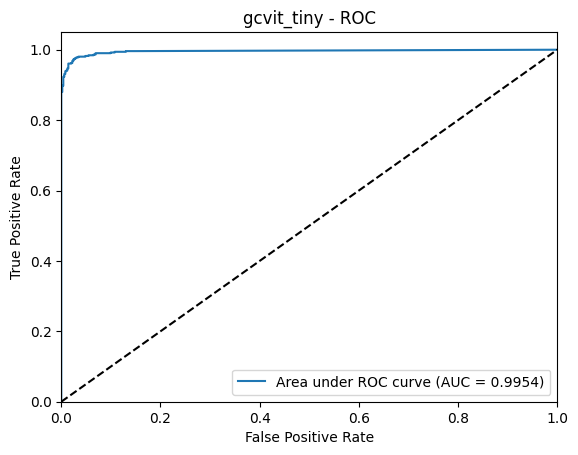

In [29]:
trainer.plot_ROC()

## Evaluation

### If you are here to evaluate already trained models, this  section is for you.

`Step 1`: Download the model weights (and optionally model.json file) from links in README.md

`Step 2`: Run this notebook upto defining  the Trainer class. No need to run the training block.

`Step 3`: Replace the `model_name`, `json_path` and `weight_path` in the next cell.

Now, run the next cells, and  it will plot the Evaluation metrics as   well as training curves for corresponding model.

In [33]:
model_name = 'swin_s3_tiny_224'
json_path = r"swin_s3_tiny_224\model.json"
weight_path =r"swin_s3_tiny_224\best_ckpt.pth"

# Creating model for usage
timm_resnet = TimmLensModel(model_name)

# Creating Trainer  object
trainer = Trainer(model_name,
                  model = timm_resnet, 
                  train_dset=train_dset,
                  val_dset= val_dset,
                  loss_type="mse",
                  optim_type="adam",
                  batch_size = 64,
                  load =True
                  )

trainer.load(path=weight_path, json_path=json_path)

  0%|          | 0/16 [00:00<?, ?it/s]

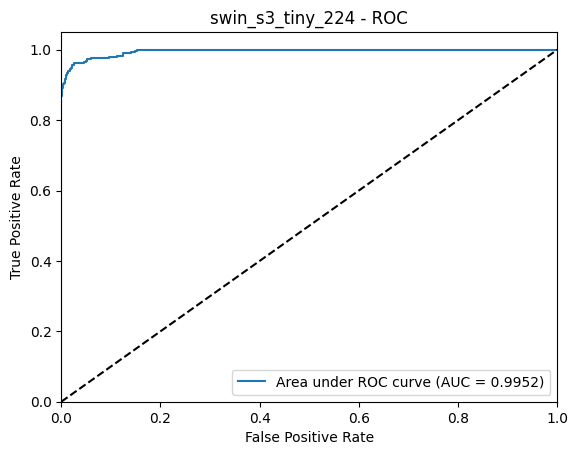

In [34]:
trainer.plot_ROC()

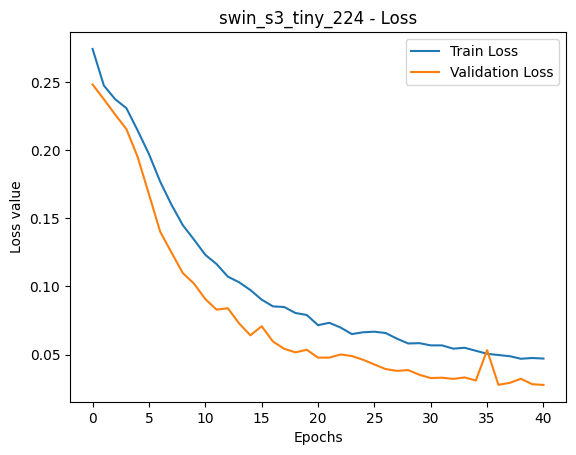

In [35]:
trainer.plot_loss()

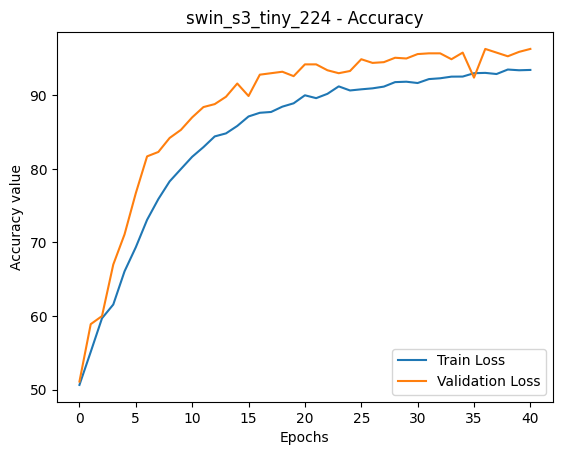

In [36]:
trainer.plot_accuracy()